In [117]:
from sdm.config import get_db_connection
from text_mining.utils import get_preprocessed_LDA
from text_mining.language import Language
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

## Task 1.3: LDA (Default)
- Run LDA with learned priors (alpha, eta).
- Choose an appropriate number of topics (K).
- Inspect topics and check if they make sense.

In [118]:
db = get_db_connection(db_path="../../../../data/twitter.db")
df = get_preprocessed_LDA(db, min_chars=1_000)
# df = get_tweet_corpora(db, min_chars=1000)
df.head()

,author_id,text_corpus,account_type,lang,stance,processed_corpus
0,8508262,L'accord de Paris adopté par les 195 pays #COP...,Private individuals,fr,For,paris adopté pays via lemondefr pcanfin ça fai...
1,3297659759,RT @ecocosmopolita: El Acuerdo de París fue me...,Advocacy actors,es,For,ecocosmopolita acuerdo parís mejor esperado le...
2,259352661,RT @RAN: Delegates at #COP21 must work to prot...,Advocacy actors,en,For,ran delegates must work protect indonesia peop...
3,955903212,RT @guardianeco: All the NGO reaction to the d...,Advocacy actors,en,For,guardianeco ngo reaction draft paris climate t...
4,2482232082,".@CFigueres: ""I used to say we must we can w...",Political actors,es,Unclear,cfigueres i used to say we must we can we will...


In [119]:
# K of ~7 seems to get the major langs, higher ones allow more granular topics and languages
# but also seems to create a lot of what seems like nonsense topics (granted most are not in english)
# and I have no idea what words/hashtags/people are in relation to the COP event.
K = 8
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_corpus'])
lda = LatentDirichletAllocation(n_components=K, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=8, random_state=42)

In [7]:
n_top_words = 15
feature_names = vectorizer.get_feature_names_out()

# Display the topics
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print("Top words")
    print("|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
Top words
climate|amp|climatechange|paris|unfccc|change|world|today|agreement|energy|lpaa|new|action|event|live

Topic #1:
Top words
acuerdo|cambioclimático|parís|climático|ambassades|cambio|clima|el|cumbre|cambioclimatico|paris|países|hoy|cmnucc|día

Topic #2:
Top words
climate|paris|climatechange|amp|change|deal|talks|world|agreement|action|new|global|text|energy|countries

Topic #3:
Top words
emblème|découvrez|vidéo|bravo|partagez|créer|contribué|tweet|découvrir|façonne|retweetez|prêt|dès|laurentfabius|royalsegolene

Topic #4:
Top words
afp|elisedepenoux|climatechange|climat|paris|amp|future|infloodwetrust|accord|pays|projet|climatique|preguntas|faqs|cop

Topic #5:
Top words
climatechange|cdnpoli|amp|climate|nuclear|design|green|climatehealth|eco|paris|ocean|text|lt|science|blog

Topic #6:
Top words
climat|pour|paris|direct|laurentfabius|accord|gt|climatique|texte|plus|du|pays|sur|fhollande|royalsegolene

Topic #7:
Top words
sassoui|nrcg|sassou|denis|nguesso|du|planète|est

In [11]:
# Like elbow method in K-means Data Mining:
perplexities = []
for k in range(2, 80, 2):
    lda = LatentDirichletAllocation(n_components=k, random_state=42, n_jobs=-1)
    lda.fit(X)
    perplexities.append({"perplexity":lda.perplexity(X), "K": k})


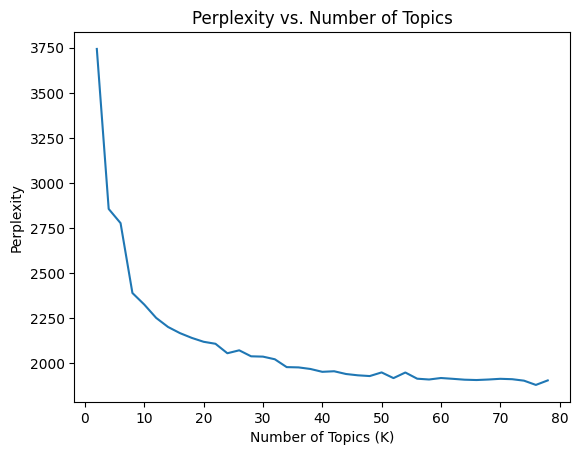

In [13]:
sns.lineplot(data=pd.DataFrame(perplexities), x="K", y="perplexity")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Topics")
plt.show()

## Task 1.4: Evaluation
- Evaluate inferred topics via blind evaluations:
  - Identify intruders.
  - Relate sampled texts to topics.
- Reflect on the evaluation process.
1. **First Task (Repeated N times):**
   - Randomly select a topic (z).
   - Randomly sample S units related to topic z (try S = 2).
   - Randomly sample 1 unit not related to topic z.
   - Shuffle the S+1 units and identify the intruder (the one not related to topic z).
   - You can adjust S if needed.

2. **Second Task (Repeated N times):**
   - Randomly select a topic (z).
   - Randomly sample S units related to topic z (try S = 1).
   - Based on the sampled units and descriptions of topics, try to identify the topic (z). 

In [16]:
def identify_intruder(doc_topic_dist, S=2):
    z = np.random.choice(doc_topic_dist.shape[1])
    
    # Get the documents that have the highest probability for topic z
    topic_probs = doc_topic_dist[:, z]
    
    # Sample S documents based on their topic probability for topic z
    sampled_docs = np.random.choice(df.index, size=S, p=topic_probs/np.sum(topic_probs), replace=False)
    
    # Pick intruder
    non_z_docs = np.where(np.max(doc_topic_dist, axis=1) != z)[0]
    non_z_doc = np.random.choice(non_z_docs)
    
    # Shuffle the S+1 documents (including the intruder)
    shuffled_docs = np.random.permutation(np.append(sampled_docs, non_z_doc))
    
    # Display the shuffled documents for you to identify the intruder
    for doc_idx in shuffled_docs:
        intruder_str = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tvvv-Intruder-vvv" if doc_idx not in sampled_docs else ""
        print(f"---Document {doc_idx}:{intruder_str}")  # - Topic Distribution: {doc_topic_dist[doc_idx]}")
        # print("|".join([feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]))
        random_words = np.random.choice(df.loc[doc_idx, :]["processed_corpus"].split(), size=10)
        print("Ten random words from corpus:")
        print("|".join(random_words))
        print("Processed Corpus:")
        print(df.loc[doc_idx, :]["processed_corpus"])
    
    print("\nTry to identify the intruder document\n")

In [17]:
N = 10
dist = lda.transform(X)
for _ in range(N):
    identify_intruder(dist, S=2)
# put scores here: <guess> (<answer>)
# finn [232 (534), 244 (244), 872 (872), 788 (788), 784 (644), 879 (364), 792 (792), 668 (204), 147 (74), 161 (161)]
# total: 5/10

---Document 693:
Ten random words from corpus:
tz|leurs|christel|du|nrcg|sassoui|congo|pour|reconnaît|sassoui
Processed Corpus:
but est reduire température moyenne planète d ici sassoui nrcg q félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite président hollande pour sassou sassoui nrcg félicite pré

In [19]:
def identify_topic_from_sample(doc_topic_dist, df, feature_names, lda, S=1, n_top_words=12):
    z = np.random.choice(doc_topic_dist.shape[1])
    
    # Get the documents that have the highest probability for topic z
    topic_probs = doc_topic_dist[:, z]
    
    # Sample S documents based on their topic probability for topic z
    sampled_docs = np.random.choice(df.index, size=S, p=topic_probs/np.sum(topic_probs), replace=False)
    
    # Print out the top terms for all topics
    print("Top terms for each topic:")
    for topic_idx, topic in enumerate(lda.components_):
        top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx}: {' | '.join(top_terms)}")
    
    print("\nSampled documents:")
    for doc_idx in sampled_docs:
        intruder_str = f"\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tvvv-Topic {z}-vvv"
        random_words = np.random.choice(df.loc[doc_idx, :]["processed_corpus"].split(), size=10)
        print(f"---Document {doc_idx}{intruder_str}")
        print("Ten random words from corpus:")
        print("|".join(random_words))
        print("Processed Corpus:")
        print(df.loc[doc_idx, :]["processed_corpus"])
    
    print("\nTry to identify the topic of the sampled documents!\n")

N = 10
for _ in range(N):
    identify_topic_from_sample(dist, df, feature_names, lda, S=1)
# put scores here:
# finn: [0 (7), 7 (3), 0 (2), 3 (7), 1 (1), 7 (7), 1 (3), 5 (7), 7 (7), 1 (1)]
# 4/10

Top terms for each topic:
Topic #0: climate | amp | climatechange | paris | unfccc | change | world | today | agreement | energy | lpaa | new
Topic #1: acuerdo | cambioclimático | parís | climático | ambassades | cambio | clima | el | cumbre | cambioclimatico | paris | países
Topic #2: climate | paris | climatechange | amp | change | deal | talks | world | agreement | action | new | global
Topic #3: emblème | découvrez | vidéo | bravo | partagez | créer | contribué | tweet | découvrir | façonne | retweetez | prêt
Topic #4: afp | elisedepenoux | climatechange | climat | paris | amp | future | infloodwetrust | accord | pays | projet | climatique
Topic #5: climatechange | cdnpoli | amp | climate | nuclear | design | green | climatehealth | eco | paris | ocean | text
Topic #6: climat | pour | paris | direct | laurentfabius | accord | gt | climatique | texte | plus | du | pays
Topic #7: sassoui | nrcg | sassou | denis | nguesso | du | planète | est | congo | bassin | brazzaville | climatiqu

## TASK 1.5: Comparison of different runs

In [29]:
orig_components = lda.components_
for _ in range(3):
    new_lda = LatentDirichletAllocation(n_components=K, random_state=_)
    new_lda.fit(X)
    for topic_idx, topic in enumerate(new_lda.components_):
        print(f"--Topic #{topic_idx}:")
        print("Top words")
        old_topic_words = "|".join([feature_names[i] for i in lda.components_[topic_idx].argsort()[:-n_top_words - 1:-1]])
        new_topic_words = "|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(f"og: {old_topic_words}")
        print(f"new: {new_topic_words}")
        print(f"Same as orig? {old_topic_words==new_topic_words}")
    print()

--Topic #0:
Top words
og: climate|amp|climatechange|paris|unfccc|change|world|today|agreement|energy|lpaa|new|action|event|live
new: climate|paris|amp|climatechange|change|world|agreement|unfccc|energy|new|today|action|deal|global|talks
Same as orig? False
--Topic #1:
Top words
og: acuerdo|cambioclimático|parís|climático|ambassades|cambio|clima|el|cumbre|cambioclimatico|paris|países|hoy|cmnucc|día
new: climat|paris|laurentfabius|accord|pour|direct|climatique|gt|afp|texte|pays|plus|ambassades|projet|royalsegolene
Same as orig? False
--Topic #2:
Top words
og: climate|paris|climatechange|amp|change|deal|talks|world|agreement|action|new|global|text|energy|countries
new: acuerdo|cambioclimático|parís|climático|afp|cambio|climatechange|clima|cumbre|el|cambioclimatico|paris|países|cmnucc|hoy
Same as orig? False
--Topic #3:
Top words
og: emblème|découvrez|vidéo|bravo|partagez|créer|contribué|tweet|découvrir|façonne|retweetez|prêt|dès|laurentfabius|royalsegolene
new: sassoui|nrcg|sassou|denis|n

## TASK 1.6: Effect of parameters
Run with:
- low and high values of Beta
- low and high values of Alpha
Docs:
```md
    doc_topic_prior : float, default=None
        Prior of document topic distribution `theta`. If the value is None,
        defaults to `1 / n_components`.
        In [1]_, this is called `alpha`.

    topic_word_prior : float, default=None
        Prior of topic word distribution `beta`. If the value is None, defaults
        to `1 / n_components`.
        In [1]_, this is called `eta`.
```

In [50]:
K = 3
# low beta
beta = .01
new_lda = LatentDirichletAllocation(n_components=K, random_state=42,
                                     topic_word_prior=beta)
new_lda.fit(X)
print(f"Beta = {beta}")
for topic_idx, topic in enumerate(new_lda.components_):
    print(f"--Topic #{topic_idx}:")
    top_words= "|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(f"Top words: {top_words}")

Beta = 0.01
--Topic #0:
Top words: emblème|vidéo|découvrez|bravo|créer|partagez|contribué|climat|afp|paris|laurentfabius|accord|pour|climatique|direct
--Topic #1:
Top words: sassoui|nrcg|sassou|denis|nguesso|du|est|planète|congo|bassin|brazzaville|climatique|réchauffement|contre|au
--Topic #2:
Top words: climate|paris|amp|climatechange|change|world|agreement|unfccc|energy|today|new|action|global|deal|need


In [51]:
# High beta
beta = .99
new_lda = LatentDirichletAllocation(n_components=K, random_state=42,
                                     topic_word_prior=beta)
new_lda.fit(X)
print(f"Beta = {beta}")
for topic_idx, topic in enumerate(new_lda.components_):
    print(f"--Topic #{topic_idx}:")
    top_words= "|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(f"Top words: {top_words}")

Beta = 0.99
--Topic #0:
Top words: emblème|vidéo|découvrez|bravo|créer|partagez|contribué|climat|afp|paris|laurentfabius|accord|pour|climatique|direct
--Topic #1:
Top words: sassoui|nrcg|sassou|denis|nguesso|du|est|planète|congo|bassin|brazzaville|climatique|réchauffement|contre|au
--Topic #2:
Top words: climate|paris|amp|climatechange|change|world|agreement|unfccc|energy|today|new|action|global|deal|need


In [52]:
# Low alpha
alpha = .01
new_lda = LatentDirichletAllocation(n_components=K, random_state=42,
                                     doc_topic_prior=alpha)
new_lda.fit(X)
print(f"Alpha = {alpha}")
for topic_idx, topic in enumerate(new_lda.components_):
    print(f"--Topic #{topic_idx}:")
    top_words= "|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(f"Top words: {top_words}")

Alpha = 0.01
--Topic #0:
Top words: emblème|vidéo|découvrez|bravo|créer|partagez|contribué|climat|paris|afp|laurentfabius|accord|pour|climatique|direct
--Topic #1:
Top words: sassoui|nrcg|sassou|denis|nguesso|du|est|planète|congo|bassin|brazzaville|climatique|réchauffement|contre|au
--Topic #2:
Top words: climate|paris|amp|climatechange|change|world|agreement|unfccc|energy|today|new|action|global|deal|need


In [53]:
# High alpha
alpha = .99
new_lda = LatentDirichletAllocation(n_components=K, random_state=42,
                                     doc_topic_prior=alpha)
new_lda.fit(X)
print(f"Alpha = {alpha}")
for topic_idx, topic in enumerate(new_lda.components_):
    print(f"--Topic #{topic_idx}:")
    top_words= "|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(f"Top words: {top_words}")

Alpha = 0.99
--Topic #0:
Top words: emblème|vidéo|découvrez|bravo|créer|partagez|contribué|climat|paris|afp|laurentfabius|accord|pour|climatique|direct
--Topic #1:
Top words: sassoui|nrcg|sassou|denis|nguesso|du|est|planète|congo|bassin|brazzaville|climatique|contre|réchauffement|au
--Topic #2:
Top words: climate|paris|amp|climatechange|change|world|agreement|unfccc|energy|today|new|action|global|deal|need


I dont see any real difference between the words. Also, I cant figure out how to make alpha asymmetric in sklearn.

Quote from the lab: "Being a symmetric distribution, both Alpha and Beta are scalars, you only need to provide a single number." 

Love, Thea

## TASK 1.7:  Learning your similarity functions

For this last task with LDA, run the model with different values of K. Then randomly pick N pairs of units (without using any information about the results of the models) and rate them on a three-level scale (unrelated, somehow related, very related). Use this information to assess the different results.

In [112]:
ratings = []
for k in range(2, 15, 3):
    print(f"K={k}")
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(X)

    random_indices = np.random.choice(X.shape[0], 10, replace=True)
    for i in range(0, len(random_indices), 2):
        pair = (random_indices[i], random_indices[i+1])
        topic_pair = (
            lda_model.fit_transform(X[pair[0]]).argmax(),
            lda_model.fit_transform(X[pair[1]]).argmax(),
        )
        random_rating = np.random.randint(0, 3)
        lda_rating = 2 if topic_pair[0] == topic_pair[1] else 0
        text_pair = (
            df.loc[pair[0], 'processed_corpus'][:100],
            df.loc[pair[1], 'processed_corpus'][:100]
            )
        ratings.append({
            "K": k,
            "pair": pair,
            "text_pair": text_pair,
            "random_rating": random_rating,
            "lda_rating": lda_rating,
            })
        print(f"Unit 1: {text_pair[0]}")
        print(f"Unit 2: {text_pair[1]}")
        print()

    # print(f"K: {k}, Ratings: {ratings}")

K=2
Unit 1: unfccc cfigueres we must we can we will and we did pres hollande rauhanomaisin amp kaunein vallankum
Unit 2: beautiful speech old girl marshall islands praising parisagreement billclinton pact means need quick

Unit 1: work done team sa year culmination ensure favorable outcome sa africa world proud sa well represente
Unit 2: providing climate resilience strategies nepal women farmers providing climate resilience strategies 

Unit 1: meganrowling pretty clearly throws poor vulnerable people bus brandoncwu find lifeboat parisagreemen
Unit 2: statedept historic moment parisagreement adopted actonclimate today paris world collectively agreed 

Unit 1: worldbank weeks look highlights amp outcomes paris gfdrr colombo leverages gfdrr support become city
Unit 2: las estadísticas cuentan las historias de los desplazados via unccdcso review yesterday press confer

Unit 1: unfccc journalists hard work media center preparing parisagreement concluded fcoclimate read new tex
Unit 2: man

In [114]:
df_eval = pd.DataFrame(ratings)
finn_rating = [0, 0, 1, 0, 2,
               0, 0, 0, 0, 0,
               2, 2, 1, 0, 0,
               0, 0, 0, 0, 0,
               0, 0, 0, 0, 0]
df_eval["finn_rating"] = finn_rating
df_eval

,K,pair,text_pair,random_rating,lda_rating,finn_rating
0,2,"(653, 779)",(unfccc cfigueres we must we can we will and w...,2,2,0
1,2,"(308, 918)",(work done team sa year culmination ensure fav...,2,2,0
2,2,"(25, 831)",(meganrowling pretty clearly throws poor vulne...,2,2,1
3,2,"(915, 464)",(worldbank weeks look highlights amp outcomes ...,2,2,0
4,2,"(839, 311)",(unfccc journalists hard work media center pre...,2,0,2
5,5,"(691, 345)",(undp live watch scheuerjo answers qs ajenglis...,1,0,0
6,5,"(917, 306)",(deal sends signal markets trigger massive inv...,1,0,0
7,5,"(956, 278)",(الوزير كيري يبتسم عقب مفاجأته من قبل فريقه بك...,2,0,0
8,5,"(502, 599)",(climate deal agreed goodenergy powerful art i...,1,0,0
9,5,"(486, 62)",(elisedepenoux après de de paris salle liesse ...,1,0,0


In [115]:
df_eval.describe()

,K,random_rating,lda_rating,finn_rating
count,25.000000,25.000000,25.000000,25.000000
mean,8.000000,1.200000,0.400000,0.320000
std,4.330127,0.816497,0.816497,0.690411
min,2.000000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,0.000000
75%,11.000000,2.000000,0.000000,0.000000
max,14.000000,2.000000,2.000000,2.000000


## TASK 1.8:  Empirical analysis: Topics & producers
Show association to metadata (stance or type)

In [ ]:
K = 8
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_corpus'])
lda = LatentDirichletAllocation(n_components=K, random_state=42)
lda.fit(X)

In [ ]:
df["topics"] = [x.argmax() for x in lda.transform(X)]


0      6
1      1
2      0
3      0
4      0
      ..
957    4
958    0
959    4
960    0
961    7
Name: topics, Length: 962, dtype: int64

<Axes: xlabel='topics', ylabel='count'>

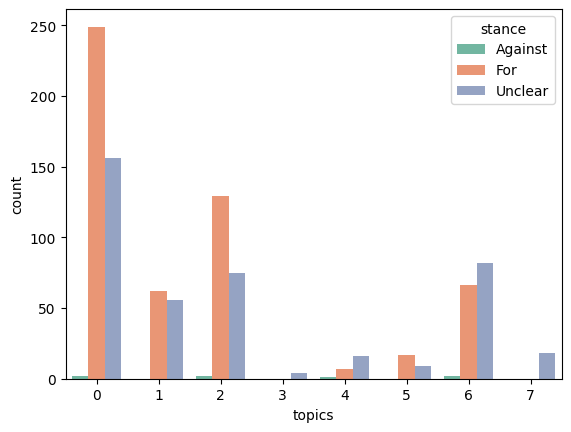

In [158]:
sns.barplot(data=df.groupby(['topics', 'stance']).size().reset_index(name='count'), x="topics", y="count", hue="stance", palette="Set2")

In [157]:
# df.groupby(["topics", ""]).count()
df.groupby(['topics', 'stance']).size().reset_index(name='count')

,topics,stance,count
0,0,Against,2
1,0,For,249
2,0,Unclear,156
3,1,For,62
4,1,Unclear,56
5,2,Against,2
6,2,For,129
7,2,Unclear,75
8,3,Unclear,4
9,4,Against,1
